<a href="https://colab.research.google.com/github/rizkamars/IndiHome-Eazy/blob/main/IndiHome_Eazy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Aplikasi *IndiHome Eazy* merupakan bagian dari layanan *IndiHome Smart* milik PT Telkom Indonesia yang berfungsi sebagai platform pengelola perangkat rumah pintar, khususnya kamera CCTV. Dalam penggunaannya, aplikasi ini mendapatkan berbagai ulasan dari pengguna di Google Play Store, mulai dari pujian atas kemudahan dan kegunaannya hingga keluhan teknis terkait kestabilan dan aksesibilitas. Studi kasus ini bertujuan untuk **menganalisis sentimen pengguna terhadap aplikasi IndiHome Eazy**, mengidentifikasi pola keluhan dan pujian berdasarkan ulasan pengguna, serta menyusun strategi perbaikan produk guna meningkatkan kepuasan pelanggan dan mendorong lebih banyak ulasan positif.

Sebagai bagian dari analisis, digunakan metode *Latent Dirichlet Allocation (LDA)* untuk menggali topik-topik utama dalam ulasan. Hasilnya menunjukkan bahwa ulasan positif banyak berkaitan dengan kepuasan terhadap fitur kamera, kemudahan penggunaan, serta manfaat aplikasi dalam memantau rumah. Di sisi lain, ulasan negatif mengungkap masalah serius seperti aplikasi yang sulit dibuka, sering mengalami *crash*, dan gangguan pada fungsi CCTV terutama setelah pembaruan dilakukan. Dengan menggabungkan analisis sentimen dan topik, studi ini berupaya memberikan gambaran menyeluruh mengenai pengalaman pengguna serta menawarkan rekomendasi strategis untuk meningkatkan kualitas layanan dan persepsi publik terhadap aplikasi.

# IMPORT LIBRARY

In [ ]:
!pip install google-play-scraper
!pip install Sastrawi
!pip install gensim

In [ ]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.dates as mdates
from wordcloud import WordCloud
from google_play_scraper import reviews, Sort
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from gensim.models import LdaModel
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel

# DATA GATHERING

In [ ]:
result, _ = reviews(
    'com.telkom.indihome.smart',
    lang='id',
    country='id',
    sort=Sort.NEWEST,
    count=5000,
    filter_score_with=None
)
df = pd.DataFrame(result)
df.head(10)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,09b77a5f-db06-4741-a64c-99bf8721f472,Teddy S,https://play-lh.googleusercontent.com/a-/ALV-U...,"indihome gangguan terus, penanganan gangguan l...",1,0,None,2025-06-25 00:47:38,None,NaT,None
1,731c204c-3427-42ed-81df-9008d07ee58e,HARKI KI,https://play-lh.googleusercontent.com/a-/ALV-U...,mantap,5,0,4.5.2,2025-04-24 15:38:56,None,NaT,4.5.2
2,e4692265-e0fa-480c-937f-839593a49e21,saiful amri,https://play-lh.googleusercontent.com/a-/ALV-U...,"setelah saya update malah tidak bisa, setelah ...",1,3,4.5.1,2025-04-20 18:08:15,None,NaT,4.5.1
3,e22dd458-b8fa-45e7-8079-a020eac118b0,Wildan Arsy Gracia,https://play-lh.googleusercontent.com/a-/ALV-U...,gak ada respon sama sekali,1,0,4.4.1,2025-04-12 02:11:48,None,NaT,4.4.1
4,ddb96c34-726d-457d-a6f8-c2e9dc226e26,Adhitya Gaming,https://play-lh.googleusercontent.com/a-/ALV-U...,indihome easy.Easy to get 1 star,1,0,None,2025-03-21 10:38:37,None,NaT,None
5,17774e54-dddc-4964-bdda-92d68d51342a,raje dore,https://play-lh.googleusercontent.com/a-/ALV-U...,Jaringan indihome macam taik,1,0,3.1.3,2025-03-02 12:05:14,None,NaT,3.1.3
6,d741a042-1ee2-4f74-b5bf-53735ce77564,Munir Asrori,https://play-lh.googleusercontent.com/a-/ALV-U...,Jaringan ngelag padahal cuman buat game standar,1,0,None,2025-02-28 16:04:15,None,NaT,None
7,e331418c-b510-43e0-b058-296cc2147f71,Syarif Cs,https://play-lh.googleusercontent.com/a-/ALV-U...,Ok,5,0,4.4.1,2025-02-06 06:52:45,None,NaT,4.4.1
8,dceeae75-636d-4915-81bd-bd0e6a74bcd1,Abd Hamid Hamid,https://play-lh.googleusercontent.com/a/ACg8oc...,Bagus cuma susah membuka kamera,3,0,None,2024-12-26 13:29:17,None,NaT,None
9,b786f524-711a-4bb4-88eb-f9cbb820f21f,alvungki,https://play-lh.googleusercontent.com/a-/ALV-U...,Kenapa aplikasi sering bug dan minta paksa hen...,2,1,4.4.1,2024-10-06 05:11:00,None,NaT,4.4.1


In [ ]:
df = pd.DataFrame(result)
df = df[['userName', 'content', 'score', 'at']].rename(columns={
    'userName': 'username',
    'content': 'review',
    'score': 'score',
    'at': 'date'
})
df = df[df['review'].str.strip() != '']
df['date'] = pd.to_datetime(df['date'])

total_reviews = len(df)
print("="*60)
print(f"Total Ulasan yang Berhasil Diambil : {total_reviews} ulasan")
print("="*60)

df.head()

Total Ulasan yang Berhasil Diambil : 920 ulasan


,username,review,score,date
0,Teddy S,"indihome gangguan terus, penanganan gangguan l...",1,2025-06-25 00:47:38
1,HARKI KI,mantap,5,2025-04-24 15:38:56
2,saiful amri,"setelah saya update malah tidak bisa, setelah ...",1,2025-04-20 18:08:15
3,Wildan Arsy Gracia,gak ada respon sama sekali,1,2025-04-12 02:11:48
4,Adhitya Gaming,indihome easy.Easy to get 1 star,1,2025-03-21 10:38:37


# LABELING

In [ ]:
def label_sentiment(score):
    if score >= 4:
        return 'positif'
    elif score == 3:
        return 'netral'
    else:
        return 'negatif'

df['sentimen'] = df['score'].apply(label_sentiment)

# PREPROCESSING

In [ ]:
# Kamus normalisasi kata tidak baku → baku
normalization_dict = {
    'gak': 'tidak',
    'ga': 'tidak',
    'gk': 'tidak',
    'nggak': 'tidak',
    'ngga': 'tidak',
    'ngk': 'tidak',
    'bgt': 'banget',
    'dr': 'dari',
    'tp': 'tapi',
    'tdk': 'tidak',
    'udh': 'sudah',
    'sdh': 'sudah',
    'blm': 'belum',
    'dgn': 'dengan',
    'bgus': 'bagus',
    'bgs': 'bagus',
    'trs': 'terus',
    'utk': 'untuk',
    'aja': 'saja',
    'jg': 'juga',
    'bikin': 'buat',
    'sy': 'saya',
    'lg': 'lagi',
    'klo': 'kalau',
    'klw': 'kalau',
    'msh':'masih'
}

In [ ]:
# Fungsi normalisasi
def normalize_text(text):
    words = text.split()
    normalized_words = [normalization_dict.get(word, word) for word in words]
    return ' '.join(normalized_words)

# Stopword tambahan
extra_stopwords = ['yg', 'nya', 'sih', 'aja', 'dong', 'nih', 'deh', 'lho', 'kok']

In [ ]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

stop_factory = StopWordRemoverFactory()
stopwords = stop_factory.get_stop_words()

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    text = text.strip()
    words = text.split()
    words = [word for word in words if word not in stopwords and word not in extra_stopwords]
    text = ' '.join(words)
    text = normalize_text(text)
    return stemmer.stem(text)

df['cleaned_review'] = df['review'].apply(clean_text)
df.to_csv('IndiHomeEazyCleaned.csv', index=False, encoding='utf-8-sig')
df[['review', 'cleaned_review']].sample(10, random_state=42)

,review,cleaned_review
319,Mohon di tingkatkan kualitas performa yang leb...,mohon tingkat kualitas performa lebih baik uba...
377,Sangat buruk,sangat buruk
538,Bagus,bagus
296,"CACAT, APPS KALO MAU UPDATE, TRIAL & EROR DULU...",cacat apps kalo mau update trial eror dulu jan...
531,Kualitasnya sangat buruk,kualitas sangat buruk
70,Saya mau pasang indihome dan pelayanan nya san...,mau pasang indihome layan sangat lama tunda tu...
493,Mantap,mantap
664,Excelent,excelent
796,Bagus,bagus
30,"Apk crash,",apk crash


# EDA

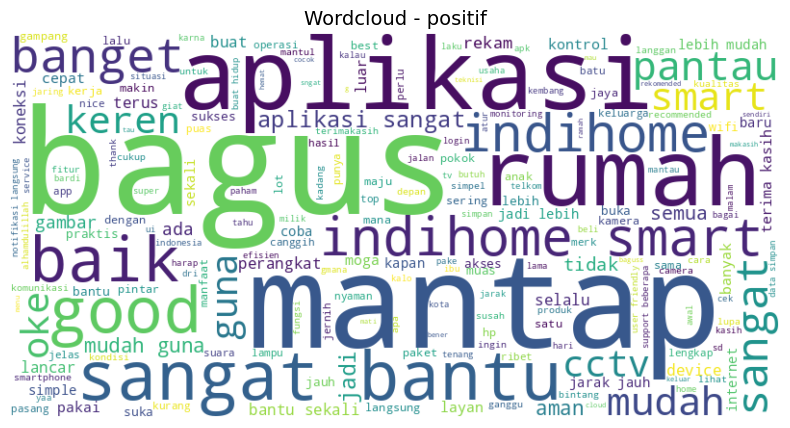

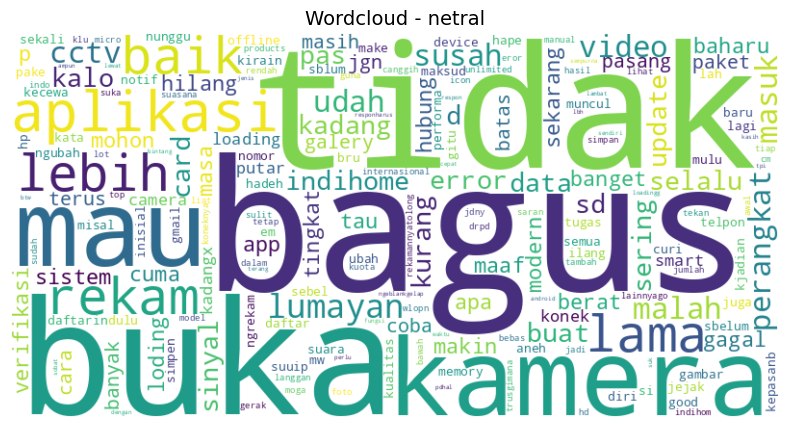

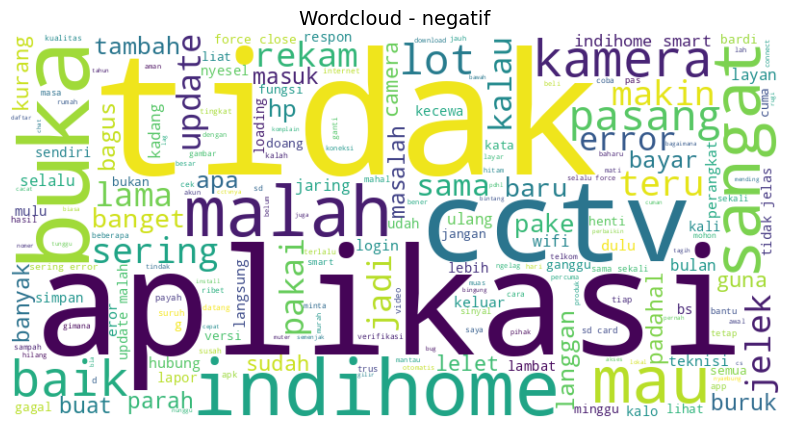

In [ ]:
def generate_wordcloud(data, label):
    text = ' '.join(data[data['sentimen'] == label]['cleaned_review'])
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Wordcloud - {label}', fontsize=14)
    plt.show()

generate_wordcloud(df, 'positif')
generate_wordcloud(df, 'netral')
generate_wordcloud(df, 'negatif')

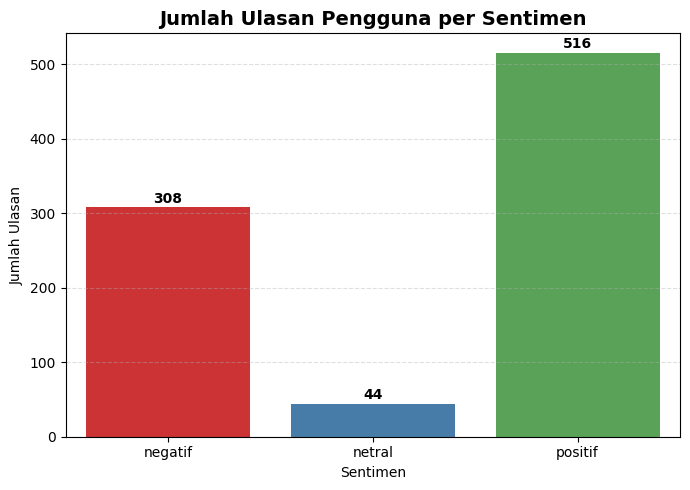

In [ ]:
users_per_sentimen = df.groupby('sentimen')['username'].nunique().reset_index(name='jumlah_pengguna')
plt.figure(figsize=(7, 5))
bars = sns.barplot(
    data=users_per_sentimen,
    x='sentimen',
    y='jumlah_pengguna',
    hue='sentimen',
    palette='Set1',
    legend=False
)
for index, row in users_per_sentimen.iterrows():
    plt.text(index, row['jumlah_pengguna'] + 2, row['jumlah_pengguna'],
             ha='center', va='bottom', fontweight='bold')

plt.title('Jumlah Ulasan Pengguna per Sentimen', fontsize=14, weight='bold')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah Ulasan')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

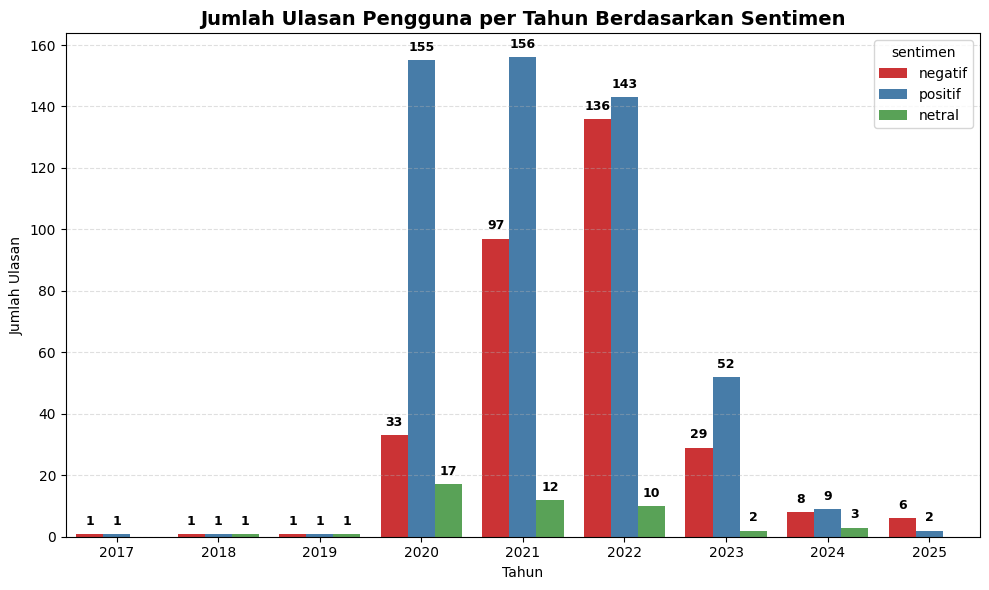

In [ ]:
df['year'] = df['date'].dt.year

users_per_year_sentimen = df.groupby(['year', 'sentimen'])['username'].nunique().reset_index(name='jumlah_pengguna')

plt.figure(figsize=(10, 6))
bars = sns.barplot(
    data=users_per_year_sentimen,
    x='year',
    y='jumlah_pengguna',
    hue='sentimen',
    palette='Set1'
)

for bar in bars.patches:
    height = bar.get_height()
    if height > 0:
        plt.text(
            x=bar.get_x() + bar.get_width() / 2,
            y=height + 2,
            s=int(height),
            ha='center', va='bottom',
            fontsize=9,
            fontweight='bold'
        )

plt.title('Jumlah Ulasan Pengguna per Tahun Berdasarkan Sentimen', fontsize=14, weight='bold')
plt.xlabel('Tahun')
plt.ylabel('Jumlah Ulasan')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

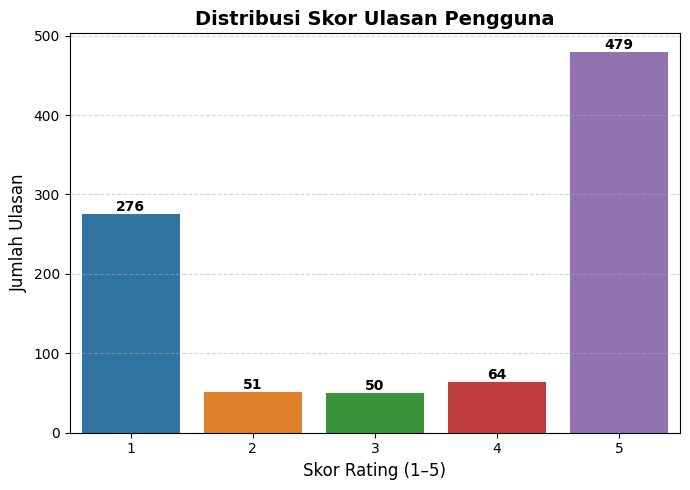

In [ ]:
plt.figure(figsize=(7, 5))
bars = sns.countplot(data=df, x='score', hue='score', palette='tab10', legend=False)

for bar in bars.patches:
    height = bar.get_height()
    if height > 0:
        bars.annotate(
            format(int(height), 'd'),
            (bar.get_x() + bar.get_width() / 2, height),
            ha='center', va='bottom',
            fontsize=10, fontweight='bold'
        )

plt.title('Distribusi Skor Ulasan Pengguna', fontsize=14, weight='bold')
plt.xlabel('Skor Rating (1–5)', fontsize=12)
plt.ylabel('Jumlah Ulasan', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

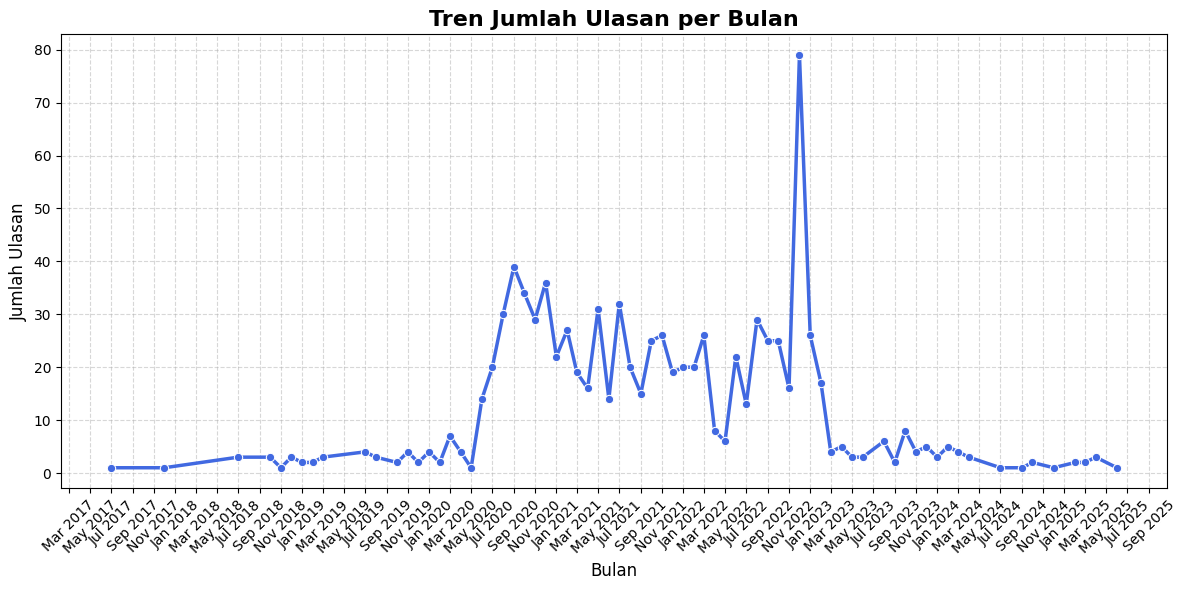

In [ ]:
df['month'] = df['date'].dt.to_period('M')
monthly_counts = df.groupby('month').size().reset_index(name='jumlah_ulasan')
monthly_counts['month'] = monthly_counts['month'].dt.to_timestamp()

plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_counts, x='month', y='jumlah_ulasan', marker='o', color='royalblue', linewidth=2.5)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))

plt.title('Tren Jumlah Ulasan per Bulan', fontsize=16, weight='bold')
plt.xlabel('Bulan', fontsize=12)
plt.ylabel('Jumlah Ulasan', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# ANALISA DESKRIPTIF

In [ ]:
df['word_count'] = df['cleaned_review'].apply(lambda x: len(x.split()))
short_words = df['cleaned_review'].apply(lambda x: sum(len(w) < 3 for w in x.split())).sum()
num_ulasan = df.shape[0]

print(f"Jumlah Ulasan: {num_ulasan}")
print(f"Jumlah Kata Pendek (<3 huruf): {short_words}")

Jumlah Ulasan: 920
Jumlah Kata Pendek (<3 huruf): 164


# TF-IDF

In [ ]:
vectorizer = TfidfVectorizer(max_features=1000)
tfidf_matrix = vectorizer.fit_transform(df['cleaned_review'])
words_freq = np.asarray(tfidf_matrix.sum(axis=0)).flatten()
words = vectorizer.get_feature_names_out()
word_freq_df = pd.DataFrame(list(zip(words, words_freq)), columns=["word", "frequency"]).sort_values(by="frequency", ascending=False)

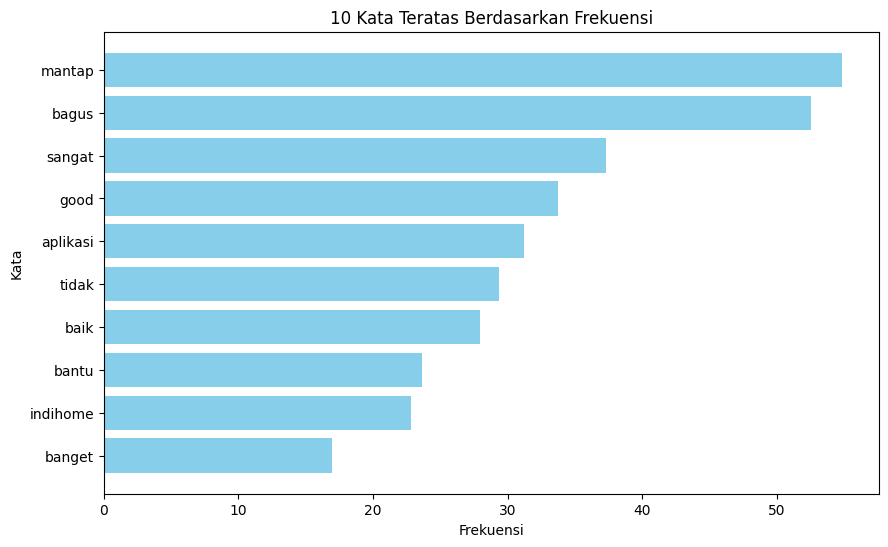

In [ ]:
plt.figure(figsize=(10, 6))
top_words = word_freq_df.head(10)
plt.barh(top_words['word'], top_words['frequency'], color='skyblue')
plt.xlabel('Frekuensi')
plt.ylabel('Kata')
plt.title('10 Kata Teratas Berdasarkan Frekuensi')
plt.gca().invert_yaxis()
plt.show()

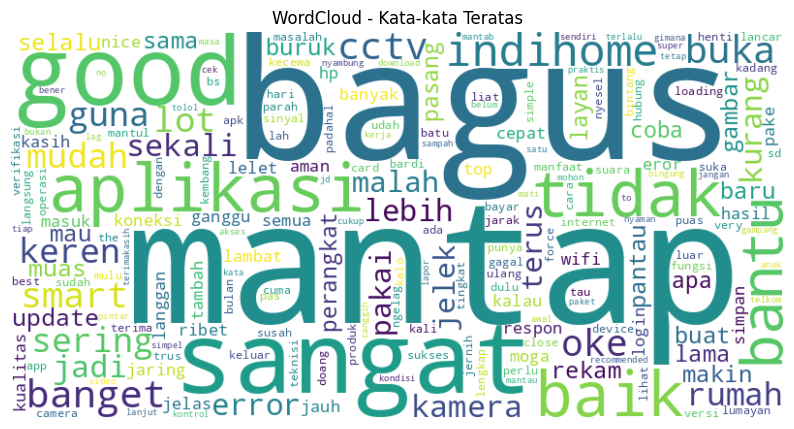

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(zip(word_freq_df['word'], word_freq_df['frequency'])))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud - Kata-kata Teratas')
plt.show()

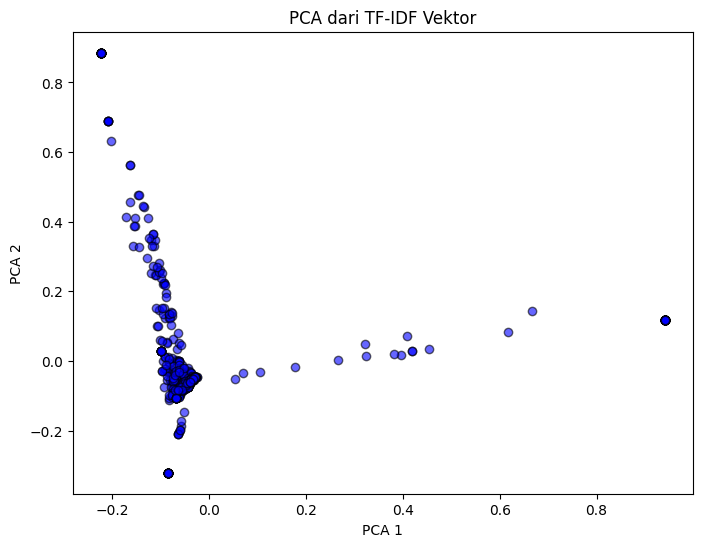

In [ ]:
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(tfidf_matrix.toarray())
plt.figure(figsize=(8, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], alpha=0.6, c='blue', edgecolors='k')
plt.title('PCA dari TF-IDF Vektor')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

# LDA

In [ ]:
df['tokenized'] = df['cleaned_review'].apply(lambda x: x.split())
dictionary = corpora.Dictionary(df['tokenized'])
corpus = [dictionary.doc2bow(text) for text in df['tokenized']]
lda_model = LdaModel(corpus, num_topics=5, id2word=dictionary, passes=10)

In [ ]:
for idx, topic in lda_model.print_topics(-1):
    print(f"Topik {idx}:\n{topic}\n")

Topik 0:
0.053*"mantap" + 0.022*"bagus" + 0.014*"aplikasi" + 0.011*"banget" + 0.011*"keren" + 0.010*"kamera" + 0.010*"cctv" + 0.009*"tidak" + 0.009*"kurang" + 0.008*"sangat"

Topik 1:
0.054*"bagus" + 0.038*"tidak" + 0.035*"good" + 0.018*"aplikasi" + 0.013*"update" + 0.011*"pakai" + 0.011*"makin" + 0.010*"buka" + 0.009*"malah" + 0.009*"jelas"

Topik 2:
0.048*"sangat" + 0.035*"aplikasi" + 0.029*"bantu" + 0.024*"indihome" + 0.021*"mudah" + 0.021*"rumah" + 0.020*"guna" + 0.019*"smart" + 0.013*"pantau" + 0.012*"tidak"

Topik 3:
0.030*"indihome" + 0.024*"baik" + 0.023*"aplikasi" + 0.019*"smart" + 0.019*"cctv" + 0.015*"sering" + 0.012*"tidak" + 0.011*"terus" + 0.009*"mau" + 0.008*"kamera"

Topik 4:
0.040*"tidak" + 0.017*"buka" + 0.016*"aplikasi" + 0.014*"oke" + 0.012*"lot" + 0.011*"cctv" + 0.009*"malah" + 0.008*"close" + 0.008*"lebih" + 0.007*"buat"



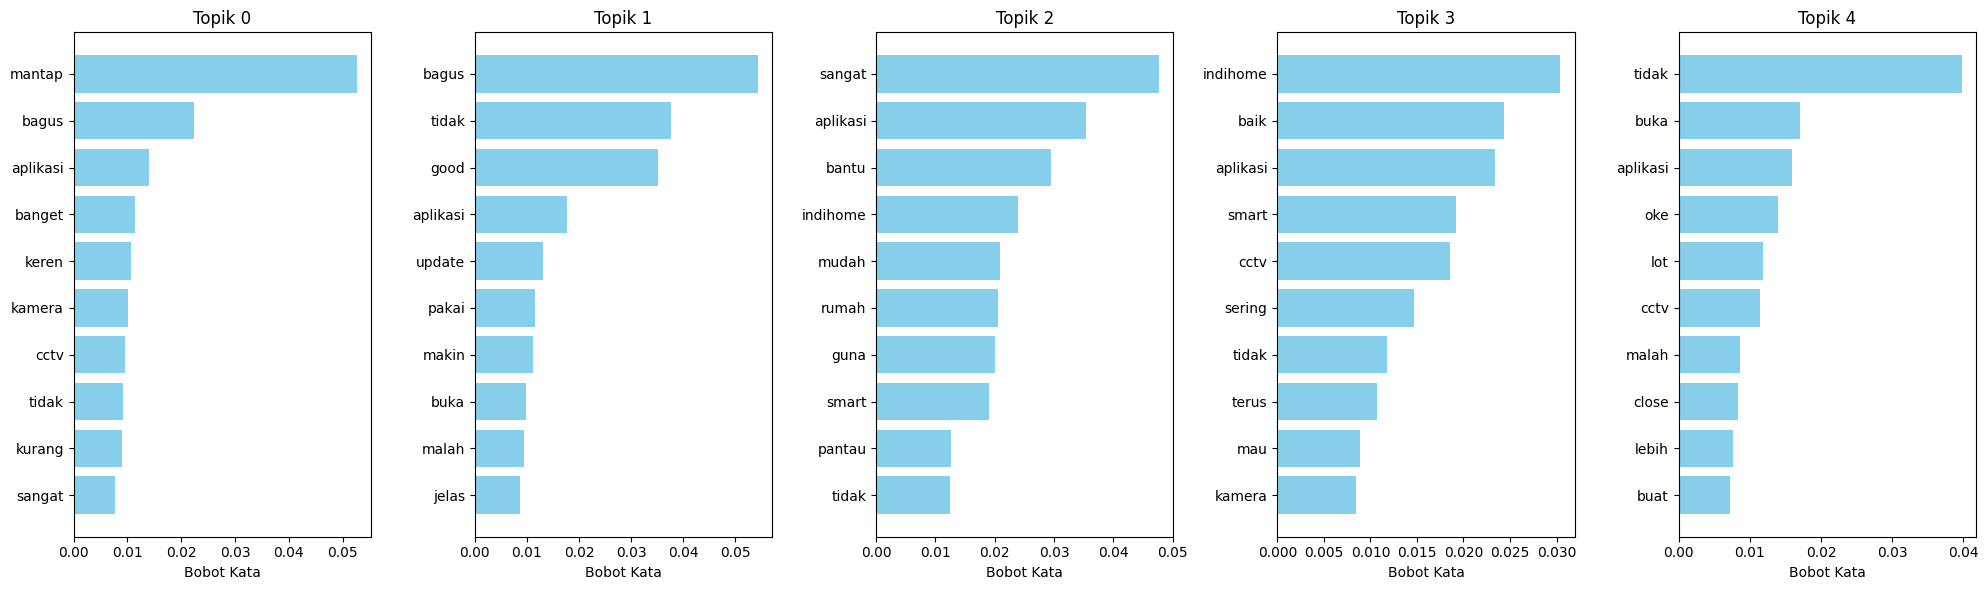

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(20, 6))
for idx in range(5):
    topic_words = lda_model.get_topic_terms(idx, topn=10)
    words = [dictionary[word_id] for word_id, _ in topic_words]
    weights = [weight for _, weight in topic_words]
    axes[idx].barh(words, weights, color='skyblue')
    axes[idx].set_title(f'Topik {idx}')
    axes[idx].invert_yaxis()
    axes[idx].set_xlabel('Bobot Kata')
plt.tight_layout()
plt.show()

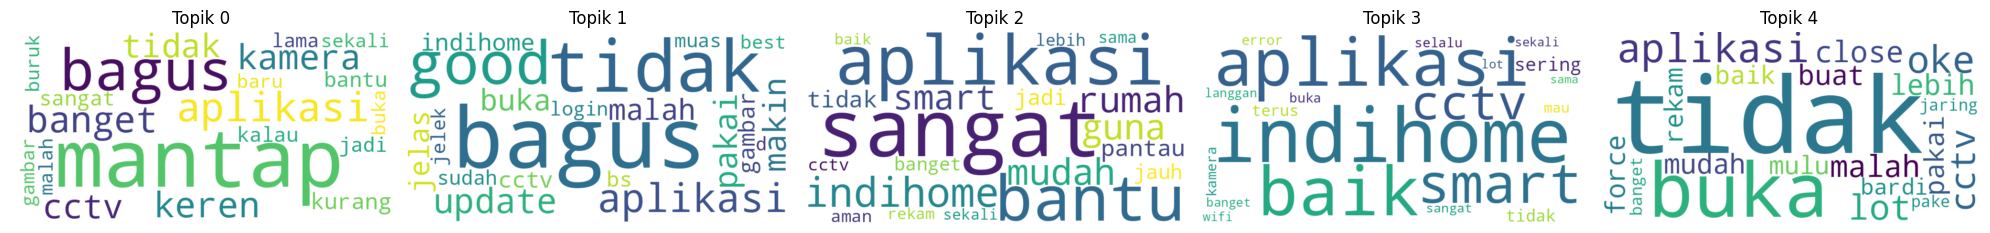

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(20, 6))
for idx in range(5):
    topic_words = lda_model.get_topic_terms(idx, topn=20)
    word_freq = {dictionary[word_id]: weight for word_id, weight in topic_words}
    wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
    axes[idx].imshow(wc, interpolation='bilinear')
    axes[idx].axis('off')
    axes[idx].set_title(f'Topik {idx}')
plt.tight_layout()
plt.show()

# EVALUASI MODEL

In [ ]:
coherence_model = CoherenceModel(model=lda_model, texts=df['tokenized'].tolist(), dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()
print(f"Coherence Score (5 topik): {coherence_score:.4f}")

Coherence Score (5 topik): 0.4788


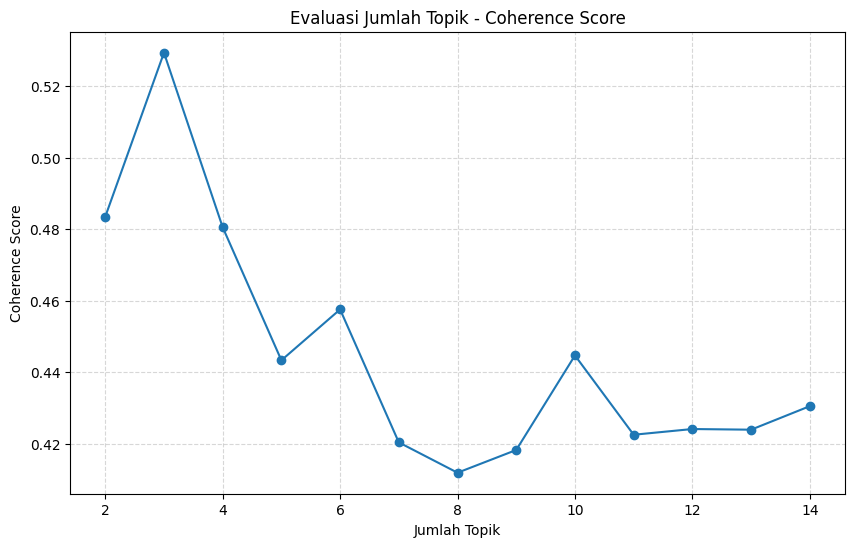

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    coherence_values = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=10)
        coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
    return coherence_values

limit = 15
coherences = compute_coherence_values(dictionary, corpus, df['tokenized'].tolist(), limit=limit)

plt.figure(figsize=(10, 6))
plt.plot(range(2, limit), coherences, marker='o')
plt.xlabel('Jumlah Topik')
plt.ylabel('Coherence Score')
plt.title('Evaluasi Jumlah Topik - Coherence Score')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# INSIGHT

| No | Aspek                      | Temuan/Insight                                                                                                              | Saran Strategis                                                                                                                                                            |
| -- | -------------------------- | --------------------------------------------------------------------------------------------------------------------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| 1  | Tren Waktu                 | Lonjakan ulasan terjadi pada Januari–Maret dan Juni–Agustus terutama pada tahun 2020 hingga 2023, dengan puncak tertinggi terjadi pada November 2022. Umumnya berkaitan dengan update besar, promosi, atau gangguan. | Fokuskan peningkatan kualitas dan stabilitas aplikasi pada periode-periode sensitif tersebut. Lakukan uji coba menyeluruh sebelum rilis dan promosi besar.                 |
| 2  | Kata Kunci Negatif         | Kata-kata seperti "buka", "error", "rekam", "update", dan "cctv" sering muncul dalam ulasan negatif.                        | Prioritaskan stabilitas fitur utama, terutama akses aplikasi, rekaman CCTV, dan kecepatan login. Lakukan analisis kata mingguan untuk pelacakan isu teknis.                |
| 3  | Stabilitas & Aksesibilitas | Banyak ulasan negatif menyebut aplikasi sulit dibuka atau error setelah update.                                             | Lakukan regression testing sebelum rilis, pasang sistem log error, dan tambahkan fitur auto-diagnosis serta “lapor masalah” satu klik dari aplikasi.                       |
| 4  | Edukasi Setelah Update     | Pengguna sering bingung dengan perubahan UI/UX, yang menyebabkan rating menurun.                                            | Buat onboarding pop-up pasca-update, sertakan tutorial singkat di aplikasi dan Play Store, serta tuliskan changelog dengan bahasa yang ramah dan informatif.               |
| 5  | Respon Cepat di Review     | Banyak ulasan bintang rendah muncul akibat frustrasi pengguna yang tidak mendapatkan respons.                               | Bangun tim customer support untuk membalas ulasan dalam waktu maksimal 24 jam. Sertakan solusi, dan dorong pengguna mencoba versi terbaru setelah perbaikan.               |
| 6  | Dorong Ulasan Positif      | Pengalaman yang lancar cenderung menghasilkan ulasan bintang 4–5.                                                           | Tampilkan pop-up in-app rating setelah interaksi positif (misal: berhasil menyetel kamera). Gunakan pesan yang persuasif dan sopan agar pengguna terdorong memberi rating. |
| 7  | Monitoring Kata Kunci      | Isu teknis bersifat berulang, seperti lag, crash, dan login gagal, muncul di berbagai periode.                              | Buat dashboard analitik mingguan berbasis kata kunci dari ulasan terbaru. Gunakan hasilnya untuk menentukan prioritas pengembangan produk dan pengujian kualitas (QA).     |


Berdasarkan analisis sentimen terhadap ulasan aplikasi IndiHome Eazy, ditemukan lonjakan ulasan pada awal dan pertengahan tahun yang diduga dipicu oleh pembaruan fitur, promosi, atau gangguan layanan. Meskipun ulasan positif mendominasi, banyak keluhan teknis muncul terkait aksesibilitas dan kestabilan, dengan kata-kata seperti "buka", "error", dan "rekam" sering ditemukan dalam ulasan negatif. Sebaliknya, ulasan positif menonjolkan kata-kata seperti "bagus", "mantap", dan "bantu", yang mencerminkan pengalaman pengguna yang memuaskan. Untuk meningkatkan rating ke level 4–5, disarankan adanya perbaikan bug, edukasi pengguna pasca-update, respons cepat terhadap ulasan negatif, serta penyisipan permintaan ulasan setelah interaksi positif.

Sementara itu, hasil analisis topik menggunakan LDA terhadap ulasan pengguna mengungkap lima tema utama, yaitu kepuasan terhadap fitur kamera dan kemudahan penggunaan, serta berbagai keluhan teknis. Ulasan positif didominasi kata seperti "mantap", "bagus", dan "bantu", mencerminkan pengalaman yang baik. Di sisi lain, ulasan negatif menyoroti permasalahan serius seperti aplikasi yang tidak bisa dibuka, crash setelah update, dan CCTV yang sering error. Temuan ini menunjukkan bahwa meskipun aplikasi memberikan manfaat nyata, stabilitas sistem dan penanganan cepat terhadap gangguan teknis harus menjadi prioritas utama dalam pengembangan ke depan.
